In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [
    '감사합니다',
    '사랑합니다',
    '안녕하세요',
    '어머니',
    '아버지',
    '동생',
    '잘',
    '못',
    '간다',
    '나',
    '이름',
    '만나다',
    '반갑다',
    '부탁',
    '학교',
    '생일',
    '월',
    '일',
    '나이',
    '고발',
    '복습',
    '학습',
    '눈치채다',
    '오는',
    '말',
    '곱다'
]

data = np.concatenate([
    np.load('dataset/seq_감사합니다.npy'),
    np.load('dataset/seq_사랑합니다.npy'),
    np.load('dataset/seq_안녕하세요.npy'),
    np.load('dataset/seq_어머니.npy'),
    np.load('dataset/seq_아버지.npy'),
    np.load('dataset/seq_동생.npy'),
    np.load('dataset/seq_잘.npy'),
    np.load('dataset/seq_못.npy'),
    np.load('dataset/seq_간다.npy'),
    np.load('dataset/seq_나.npy'),
    np.load('dataset/seq_이름.npy'),
    np.load('dataset/seq_만나다.npy'),
    np.load('dataset/seq_반갑다.npy'),
    np.load('dataset/seq_부탁.npy'),
    np.load('dataset/seq_학교.npy'),
    np.load('dataset/seq_생일.npy'),
    np.load('dataset/seq_월.npy'),
    np.load('dataset/seq_일.npy'),
    np.load('dataset/seq_나이.npy'),
    np.load('dataset/seq_고발.npy'),
    np.load('dataset/seq_복습.npy'),
    np.load('dataset/seq_학습.npy'),
    np.load('dataset/seq_눈치채다.npy'),
    np.load('dataset/seq_오다.npy'),
    np.load('dataset/seq_말.npy'),
    np.load('dataset/seq_곱다.npy')
], axis=0)

data.shape

(11615, 30, 226)

In [5]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(11615, 30, 225)
(11615,)


In [6]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(11615, 26)

In [7]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(10453, 30, 225) (10453, 26)
(1162, 30, 225) (1162, 26)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                74240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 26)                858       
                                                                 
Total params: 77178 (301.48 KB)
Trainable params: 77178 (301.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model1.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


325/327 [============================>.] - ETA: 0s - loss: 0.8831 - acc: 0.6024
Epoch 1: val_acc improved from -inf to 0.83305, saving model to models\model1.h5
327/327 [==============================] - 7s 16ms/step - loss: 0.8816 - acc: 0.6032 - val_loss: 0.4813 - val_acc: 0.8330 - lr: 0.0010
Epoch 2/200
  4/327 [..............................] - ETA: 6s - loss: 0.5282 - acc: 0.7422

c:\Users\junseok\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


326/327 [============================>.] - ETA: 0s - loss: 0.5520 - acc: 0.7643
Epoch 2: val_acc improved from 0.83305 to 0.85112, saving model to models\model1.h5
327/327 [==============================] - 8s 25ms/step - loss: 0.5517 - acc: 0.7645 - val_loss: 0.4096 - val_acc: 0.8511 - lr: 0.0010
Epoch 3/200
325/327 [============================>.] - ETA: 0s - loss: 0.3566 - acc: 0.8510
Epoch 3: val_acc improved from 0.85112 to 0.91824, saving model to models\model1.h5
327/327 [==============================] - 5s 16ms/step - loss: 0.3558 - acc: 0.8513 - val_loss: 0.2144 - val_acc: 0.9182 - lr: 0.0010
Epoch 4/200
326/327 [============================>.] - ETA: 0s - loss: 0.2586 - acc: 0.8872
Epoch 4: val_acc did not improve from 0.91824
327/327 [==============================] - 5s 16ms/step - loss: 0.2584 - acc: 0.8872 - val_loss: 0.1811 - val_acc: 0.9157 - lr: 0.0010
Epoch 5/200
326/327 [============================>.] - ETA: 0s - loss: 0.1911 - acc: 0.9146
Epoch 5: val_acc improved

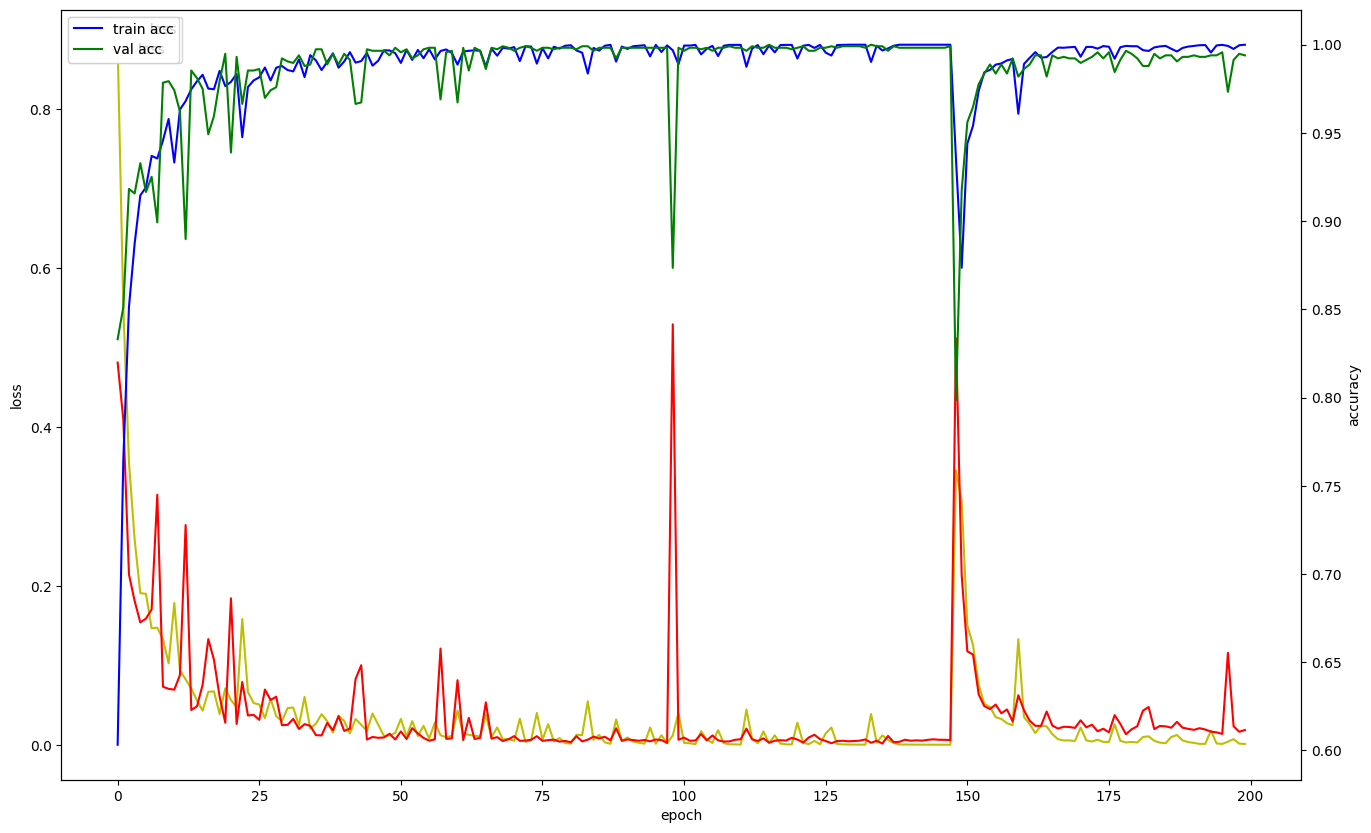

In [10]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model1.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

37/37 [==============================] - 0s 4ms/step


array([[[770,   0],
        [  0, 392]],

       [[739,   0],
        [  0, 423]],

       [[815,   0],
        [  0, 347]]], dtype=int64)